In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

c:\Arduino\ArduinoProj\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [19]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [20]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


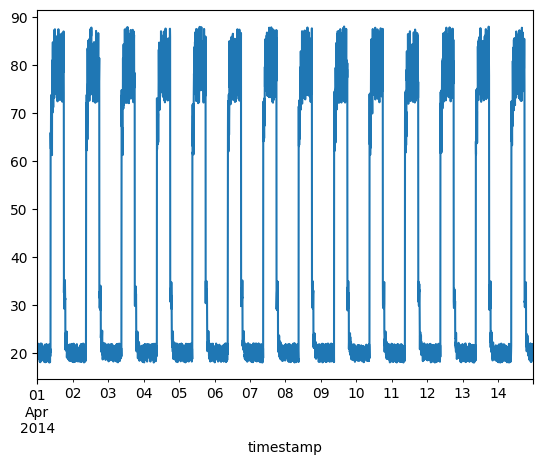

In [7]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

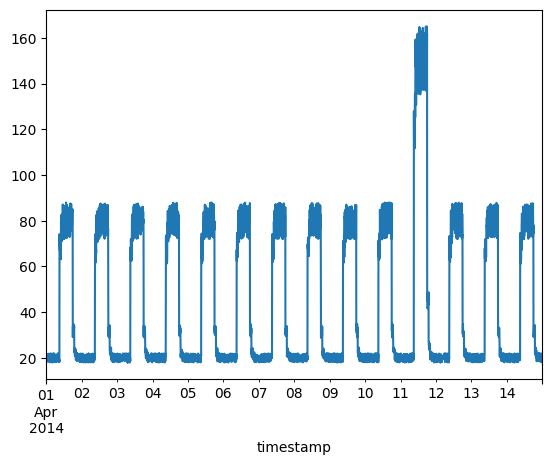

In [8]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [9]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std #standard scaling the training set
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [10]:
TIME_STEPS = 288
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [11]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 288, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7815 - val_loss: 0.1623
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1086 - val_loss: 0.0413
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0586 - val_loss: 0.0334
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0495 - val_loss: 0.0285
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0424 - val_loss: 0.0242
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0377 - val_loss: 0.0215
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0334 - val_loss: 0.0182
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0300 - val_loss: 0.0169
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0272 - val_loss: 0.0159
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0250 - val_loss: 0.0166
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0235 - val_loss: 0.0160
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

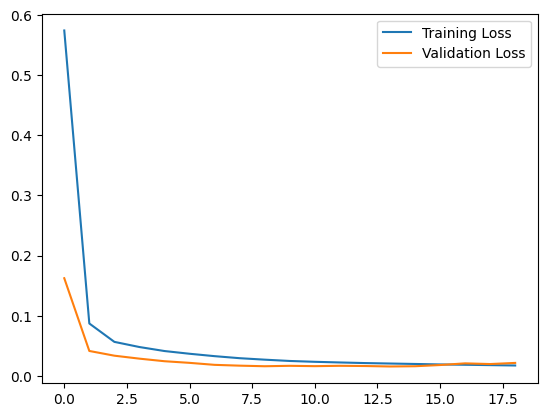

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


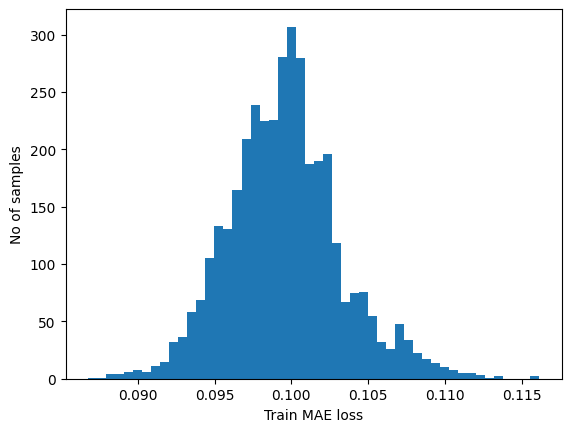

Reconstruction error threshold:  0.11614201230245408


In [14]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

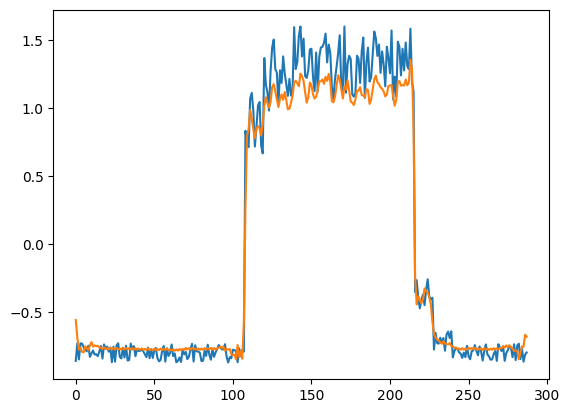

In [15]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

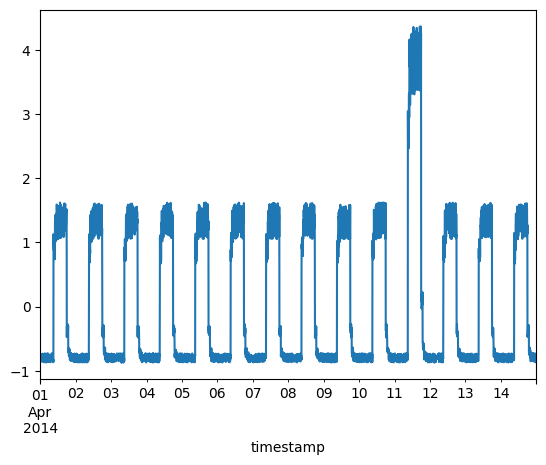

Test input shape:  (3745, 288, 1)
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


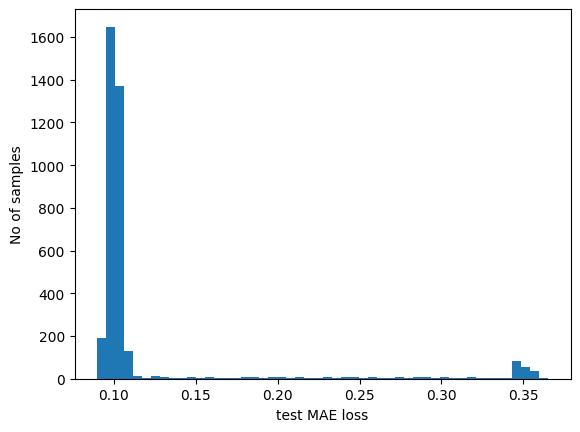

Number of anomaly samples:  392
Indices of anomaly samples:  (array([2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713,
       2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724,
       2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735,
       2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746,
       2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757,
       2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768,
       2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779,
       2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790,
       2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801,
       2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812,
       2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823,
       2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834,
       2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2

In [16]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [17]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

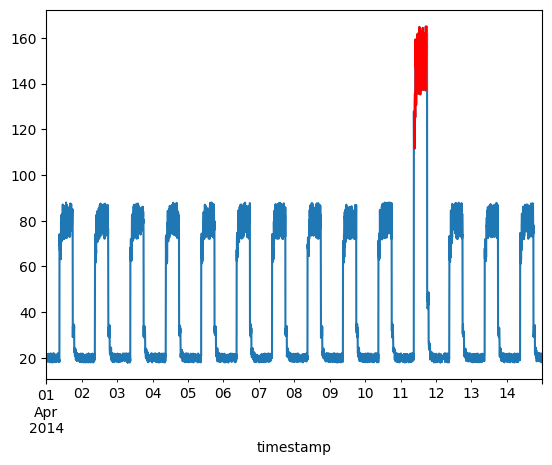

In [18]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [23]:
df_th = pd.read_csv('../time_series.csv')

In [29]:
df_th

,Unnamed: 0,T,H,Time
0,0,26.0,39.0,2
1,1,26.0,39.0,3
2,2,26.0,39.0,4
3,3,26.0,39.0,5
4,4,26.0,39.0,6
...,...,...,...,...
4995,4995,26.0,38.0,5149
4996,4996,26.0,38.0,5150
4997,4997,26.0,38.0,5151
4998,4998,26.0,38.0,5152


In [ ]:
df_th.head()
df_th.drop(columns=["Unnamed: 0"], inplace=True)

In [34]:
df_th

,T,H,Time
0,26.0,39.0,2
1,26.0,39.0,3
2,26.0,39.0,4
3,26.0,39.0,5
4,26.0,39.0,6
...,...,...,...
4995,26.0,38.0,5149
4996,26.0,38.0,5150
4997,26.0,38.0,5151
4998,26.0,38.0,5152


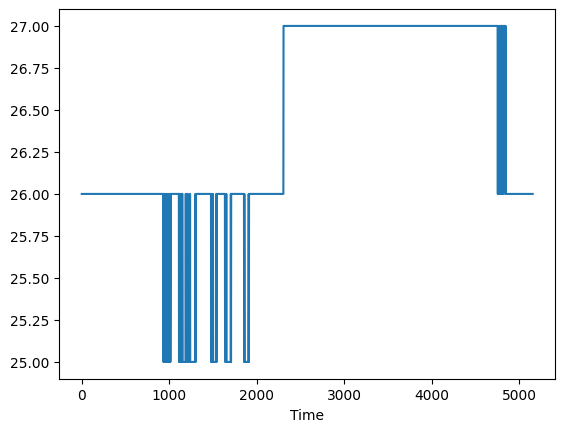

In [35]:
fig, ax = plt.subplots()
df_th.plot(legend=False, ax=ax, x = "Time", y = "T")
plt.show()

In [36]:
t_mean = df_th["T"].mean()
t_std = df_th["T"].std()
df_th["T_standardscaled"] = (df_th["T"] - t_mean) / t_std #standard scaling the training set
df_th

,T,H,Time,T_standardscaled
0,26.0,39.0,2,-0.654444
1,26.0,39.0,3,-0.654444
2,26.0,39.0,4,-0.654444
3,26.0,39.0,5,-0.654444
4,26.0,39.0,6,-0.654444
...,...,...,...,...
4995,26.0,38.0,5149,-0.654444
4996,26.0,38.0,5150,-0.654444
4997,26.0,38.0,5151,-0.654444
4998,26.0,38.0,5152,-0.654444


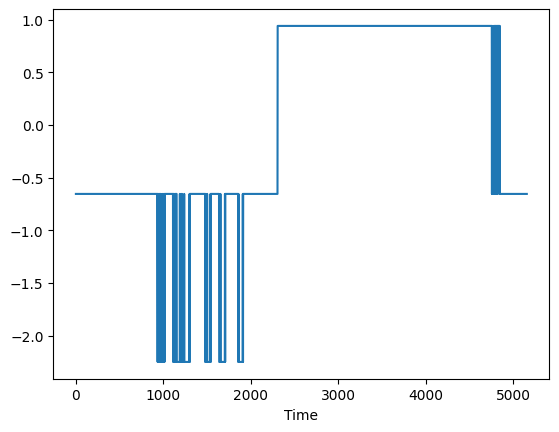

In [38]:
fig, ax = plt.subplots()
df_th.plot(legend=False, ax=ax, x = "Time", y = "T_standardscaled")
plt.show()

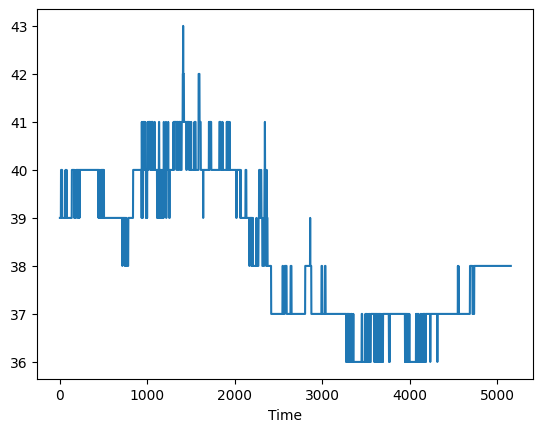

In [27]:
fig, ax = plt.subplots()
df_th.plot(legend=False, ax=ax, x = "Time", y = "H")
plt.show()

In [37]:
h_mean = df_th["H"].mean()
h_std = df_th["H"].std()
df_th["H_standardscaled"] = (df_th["H"] - h_mean) / h_std #standard scaling the training set
df_th

,T,H,Time,T_standardscaled,H_standardscaled
0,26.0,39.0,2,-0.654444,0.469262
1,26.0,39.0,3,-0.654444,0.469262
2,26.0,39.0,4,-0.654444,0.469262
3,26.0,39.0,5,-0.654444,0.469262
4,26.0,39.0,6,-0.654444,0.469262
...,...,...,...,...,...
4995,26.0,38.0,5149,-0.654444,-0.193912
4996,26.0,38.0,5150,-0.654444,-0.193912
4997,26.0,38.0,5151,-0.654444,-0.193912
4998,26.0,38.0,5152,-0.654444,-0.193912


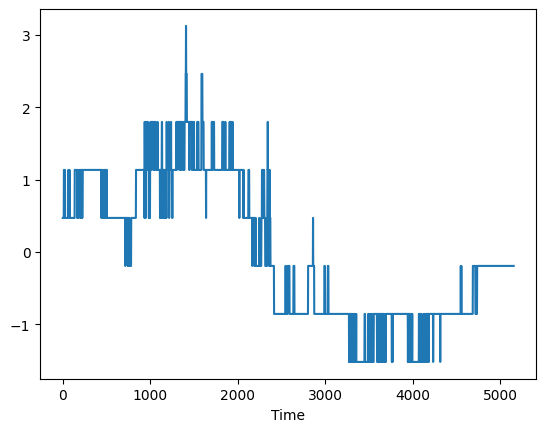

In [39]:
fig, ax = plt.subplots()
df_th.plot(legend=False, ax=ax, x = "Time", y = "H_standardscaled")
plt.show()

In [40]:
df_ath = pd.read_csv('../anom_time_series.csv')
df_ath.head()

,Unnamed: 0,T,H,Time
0,0,27.0,36.0,2
1,1,27.0,36.0,3
2,2,27.0,36.0,4
3,3,27.0,36.0,5
4,4,27.0,36.0,6


In [41]:
df_ath.drop(columns=["Unnamed: 0"], inplace=True)
df_ath

,T,H,Time
0,27.0,36.0,2
1,27.0,36.0,3
2,27.0,36.0,4
3,27.0,36.0,5
4,27.0,36.0,6
...,...,...,...
495,26.0,50.0,512
496,26.0,47.0,513
497,26.0,47.0,514
498,26.0,45.0,515


In [42]:
h_mean = df_ath["H"].mean()
h_std = df_ath["H"].std()
df_ath["H_standardscaled"] = (df_ath["H"] - h_mean) / h_std #standard scaling the training set

t_mean = df_ath["T"].mean()
t_std = df_ath["T"].std()
df_ath["T_standardscaled"] = (df_ath["T"] - t_mean) / t_std #standard scaling the training set
df_ath

,T,H,Time,H_standardscaled,T_standardscaled
0,27.0,36.0,2,-0.756669,1.331999
1,27.0,36.0,3,-0.756669,1.331999
2,27.0,36.0,4,-0.756669,1.331999
3,27.0,36.0,5,-0.756669,1.331999
4,27.0,36.0,6,-0.756669,1.331999
...,...,...,...,...,...
495,26.0,50.0,512,0.186137,-0.749250
496,26.0,47.0,513,-0.015893,-0.749250
497,26.0,47.0,514,-0.015893,-0.749250
498,26.0,45.0,515,-0.150580,-0.749250


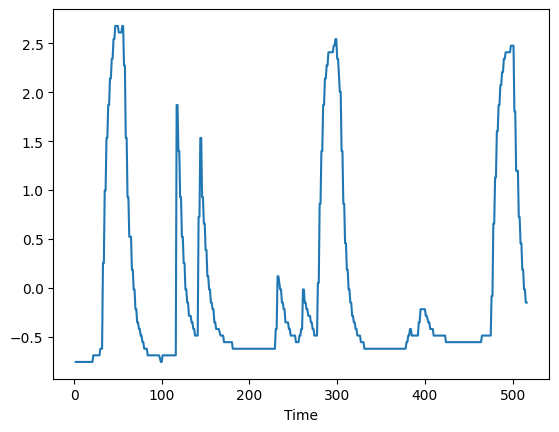

In [44]:
fig, ax = plt.subplots()
df_ath.plot(legend=False, ax=ax, x = "Time", y = "H_standardscaled")
plt.show()

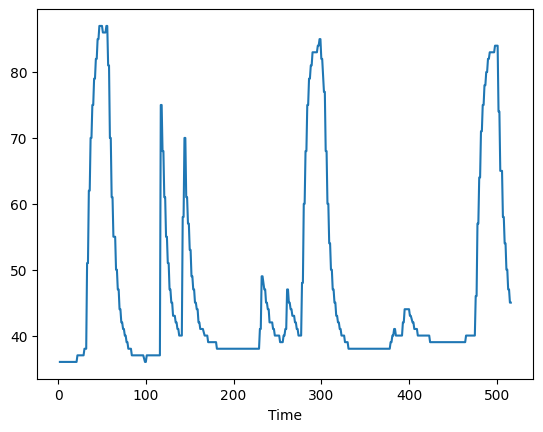

In [43]:
fig, ax = plt.subplots()
df_ath.plot(legend=False, ax=ax, x = "Time", y = "H")
plt.show()

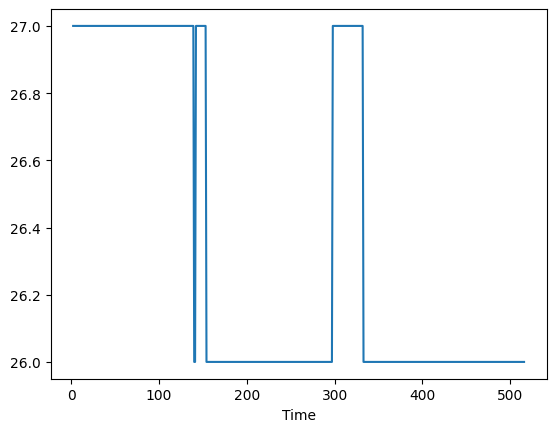

In [45]:
fig, ax = plt.subplots()
df_ath.plot(legend=False, ax=ax, x = "Time", y = "T")
plt.show()